In [136]:
import pandas as pd
import os
from os import path
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer 
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk
import numpy as np
from nltk import pos_tag
from sklearn import ensemble, metrics, model_selection, naive_bayes
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.decomposition import TruncatedSVD,NMF
import xgboost as xgb
%matplotlib inline
warnings.filterwarnings('ignore')

## Question - 1

In [3]:
root_path='review_polarity/txt_sentoken/'
reviews=['pos','neg']
mydf=pd.DataFrame(columns=['filename','review','target'])
count=0

for review in reviews:
    base_path=path.join(root_path+review)
    files=os.listdir(base_path)
    for file in files:
        with open(path.join(base_path,file)) as f:
            mydf.loc[count,:]=[file,f.read().replace('\n', ''),review]
            
        count+=1

## Question - 2

Text cleaning step is executed sequentially as follows:

- 1) Strip html characters, if any in the text and remove words between brackets as those are mostly names and are of lesser importance
- 2) Remove special characters as we see lots of unnecessary commas,single brackets and punctuations.
- 3) Lemmatize the different variants of words to have a common vocabulary
- 4) Remove the stop words

In [4]:
mydf['target']=mydf.target.replace("pos" , 1)
mydf['target']=mydf.target.replace("neg" , 0)

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\([^]]*\)', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
mydf['review']=mydf['review'].apply(denoise_text)

In [5]:
#Apply function on review column
mydf['review']=mydf['review'].apply(remove_special_characters)

In [6]:
#Lemmatize the text
def simple_lema(text):
    lemmatizer = WordNetLemmatizer() 
    text= ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    return text

#Apply function on review column
mydf['review']=mydf['review'].apply(simple_lema)

In [7]:
#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text):
    tokens = [token.strip() for token in nltk.word_tokenize(text)]
    filtered_text = ' '.join([token for token in tokens if token not in stop])
    return filtered_text

#Apply function on review column
mydf['review']=mydf['review'].apply(remove_stopwords)

## Question - 3 & 4

### Feature engineering

1. Create meta features
2. Create word features

### Meta features

In [157]:
train_df,test_df= train_test_split(mydf,test_size=0.10,random_state = 10)

In [158]:
## Number of words in the text ##
train_df["num_words"] = train_df["review"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["review"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["review"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["review"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["review"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["review"].apply(lambda x: len(str(x)))


## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [159]:
def get_number_of_nouns(taged_tokens):
    n = sum(1 for word, tag in taged_tokens if tag.startswith('NN'))
    return n


def get_number_of_adjectives(taged_tokens):
    n = sum(1 for word, tag in taged_tokens if tag.startswith('JJ'))
    return n

In [160]:

## Average length of the words in the text ##
train_df["no_nouns"] = train_df["review"].apply(lambda x: get_number_of_nouns(pos_tag(word_tokenize(x))))
test_df["no_nouns"] = test_df["review"].apply(lambda x: get_number_of_nouns(pos_tag(word_tokenize(x))))

train_df["no_adj"] = train_df["review"].apply(lambda x: get_number_of_adjectives(pos_tag(word_tokenize(x))))
test_df["no_adj"] = test_df["review"].apply(lambda x: get_number_of_adjectives(pos_tag(word_tokenize(x))))

In [161]:
cols_to_drop = ['filename', 'review','target']
train_X = train_df.drop(cols_to_drop, axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

train_y=train_df['target'].values

### Word features

In [59]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['review'].values.tolist() + test_df['review'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.tolist())

In [60]:
train_tfidf.shape

(1800, 524878)

## Question - 5 & 6

Let's run naive bayes using tfidf vectors and see the cross validation score

In [155]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict(test_X)
    pred_test_y2 = model.predict(test_X2)
    return pred_test_y, pred_test_y2, model

In [162]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.accuracy_score(val_y, pred_val_y))
    
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7855555555555556


In [163]:
confusion_matrix(val_y,pred_val_y)

array([[141,  43],
       [ 21, 155]])

Average cross validation score using tfidf vectorizer is 0.786, Now let's use these sparse tfidf features along with the meta features created above to check if its boosting the score.We can use NMF factorization method to reduce its dimensions and add it the meta features.

In [167]:
n_comp = 20
nmf_obj = NMF(n_components=20)
nmf_obj.fit(full_tfidf)
train_nmf = pd.DataFrame(nmf_obj.transform(train_tfidf))
test_nmf = pd.DataFrame(nmf_obj.transform(test_tfidf))
    
train_nmf.columns = ['nmf_word_'+str(i) for i in range(n_comp)]
test_nmf.columns = ['nmf_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df.reset_index(drop=True), train_nmf], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_nmf], axis=1)

#del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

Try out count vectorizer and see the accuracy score

In [168]:
### Fit transform the count vectorizer ###
count_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
count_vec.fit(train_df['review'].values.tolist() + test_df['review'].values.tolist())
train_cv = count_vec.transform(train_df['review'].values.tolist())
test_cv = count_vec.transform(test_df['review'].values.tolist())

In [169]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_cv[dev_index], train_cv[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.accuracy_score(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7761111111111111


Average cross validation accuracy score is 0.776 which is slightly lesser than when we used tfidf vectorizer. We will add the predictions of this model as one of the features for later use

In [170]:
# add the predictions as new features #
train_df["nb_cvec"] = pred_train
test_df["nb_cvec"] = pred_full_test

In [171]:
train_df.head()

,filename,review,target,num_words,num_unique_words,num_chars,mean_word_len,no_nouns,no_adj,nmf_word_0,...,nmf_word_11,nmf_word_12,nmf_word_13,nmf_word_14,nmf_word_15,nmf_word_16,nmf_word_17,nmf_word_18,nmf_word_19,nb_cvec
0,cv384_18536.txt,actually bad dreamworks decided release love l...,0,193,148,1415,6.336788,81,48,0.000000,...,0.000000,0.000529,0.000000,0.000000,0.0,0.000000,0.000713,0.000000,0.000000,0.0
1,cv253_10190.txt,hey ive got great idea movie ok well get tim a...,0,103,71,586,4.699029,46,24,0.012973,...,0.000660,0.001126,0.000000,0.000000,0.0,0.000000,0.000000,0.016951,0.000000,0.0
2,cv988_18740.txt,wish could say something new star war installm...,1,321,234,2260,6.043614,147,75,0.009551,...,0.000000,0.001760,0.000000,0.002319,0.0,0.001789,0.000000,0.006687,0.030275,1.0
3,cv342_19456.txt,andromeda strain greatest science fiction film...,1,305,228,2122,5.960656,147,53,0.059082,...,0.000000,0.000582,0.000601,0.000000,0.0,0.000000,0.000000,0.000356,0.000000,1.0
4,cv045_25077.txt,come average teenage romantic comedy expect ne...,0,196,166,1326,5.770408,95,49,0.000000,...,0.002832,0.000064,0.000000,0.014423,0.0,0.000000,0.010087,0.000000,0.003914,0.0


We will try character level count vectorizer to see the score again

In [174]:
### Fit transform the count vectorizer at character level ###
count_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
count_vec.fit(train_df['review'].values.tolist() + test_df['review'].values.tolist())
train_countvec = count_vec.transform(train_df['review'].values.tolist())
test_countvec = count_vec.transform(test_df['review'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_countvec[dev_index], train_countvec[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_countvec)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.accuracy_score(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char"] = pred_train
test_df["nb_cvec_char"] = pred_full_test

Mean cv score :  0.8011111111111111


The score has increased and it has crossed 80%. We will add this output also as one of the feature for later use.

Let's try the same on tfidf vectorizer.

In [176]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['review'].values.tolist() + test_df['review'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.accuracy_score(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char"] = pred_train
test_df["nb_tfidf_char"] = pred_full_test

Mean cv score :  0.7344444444444445


Tfidf vectorizer doesnt need to add additional information at character level. Let's move on and use XGB to check which features are important.

In [177]:
train_X = train_df.drop(cols_to_drop, axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [178]:
train_X.head()

,num_words,num_unique_words,num_chars,mean_word_len,no_nouns,no_adj,nmf_word_0,nmf_word_1,nmf_word_2,nmf_word_3,...,nmf_word_13,nmf_word_14,nmf_word_15,nmf_word_16,nmf_word_17,nmf_word_18,nmf_word_19,nb_cvec,nb_cvec_char,nb_tfidf_char
0,193,148,1415,6.336788,81,48,0.000000,0.002098,0.018836,0.040868,...,0.000000,0.000000,0.0,0.000000,0.000713,0.000000,0.000000,0.0,0.0,0.0
1,103,71,586,4.699029,46,24,0.012973,0.000000,0.043972,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.016951,0.000000,0.0,0.0,0.0
2,321,234,2260,6.043614,147,75,0.009551,0.001847,0.010241,0.139564,...,0.000000,0.002319,0.0,0.001789,0.000000,0.006687,0.030275,1.0,1.0,1.0
3,305,228,2122,5.960656,147,53,0.059082,0.001464,0.000000,0.008812,...,0.000601,0.000000,0.0,0.000000,0.000000,0.000356,0.000000,1.0,1.0,1.0
4,196,166,1326,5.770408,95,49,0.000000,0.002320,0.013415,0.001269,...,0.000000,0.014423,0.0,0.000000,0.010087,0.000000,0.003914,0.0,0.0,1.0


In [180]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['eval_metric'] = "error"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [181]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + np.array(pred_test_y>=0.5).astype(int)
    pred_train[val_index] = np.array(pred_val_y>=0.5).astype(int)
    cv_scores.append(metrics.accuracy_score(val_y, np.array(pred_val_y>0.5).astype(int)))
    
print("cv scores : ", cv_scores)

[0]	train-error:0.416667	test-error:0.441667
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 50 rounds.
[20]	train-error:0.188889	test-error:0.188889
[40]	train-error:0.174306	test-error:0.194444
[60]	train-error:0.164583	test-error:0.188889
Stopping. Best iteration:
[15]	train-error:0.192361	test-error:0.183333

[0]	train-error:0.403472	test-error:0.494444
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 50 rounds.
[20]	train-error:0.168056	test-error:0.252778
[40]	train-error:0.1625	test-error:0.241667
[60]	train-error:0.15625	test-error:0.241667
Stopping. Best iteration:
[16]	train-error:0.171528	test-error:0.238889

[0]	train-error:0.397222	test-error:0.463889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 50 rounds.
[20]	train-

Looks like the average cv score is coming around 0.81 with xgb. Let's see the important features from xgb and use those to build our final naive bayes model

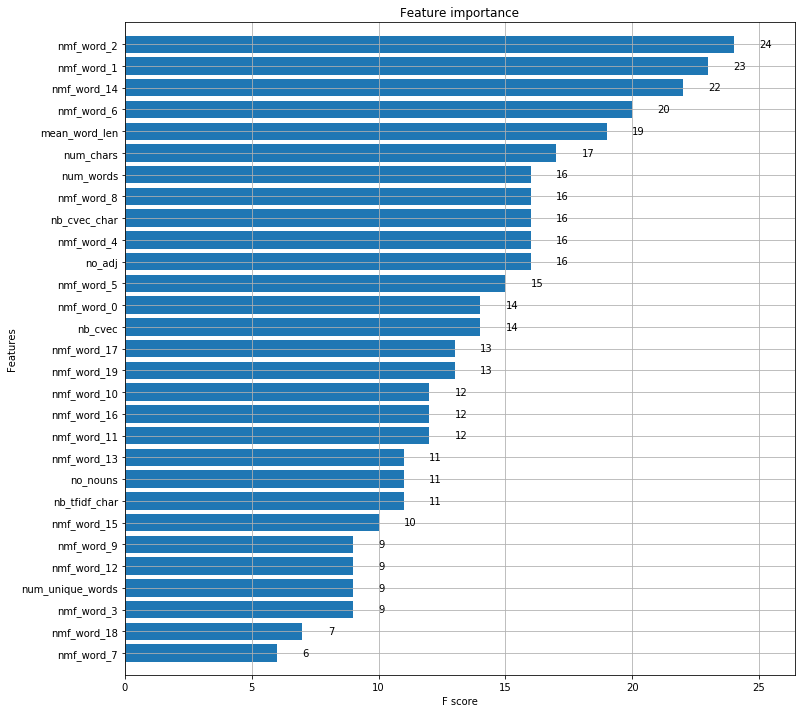

In [182]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [184]:
train_X = train_df[['nmf_word_2','nmf_word_1','nmf_word_14','nmf_word_6','mean_word_len','num_chars','num_words',
         'nmf_word_8','nb_cvec_char','nmf_word_4','no_adj','nmf_word_5','nmf_word_0','nb_cvec']]
test_X = test_df[['nmf_word_2','nmf_word_1','nmf_word_14','nmf_word_6','mean_word_len','num_chars','num_words',
         'nmf_word_8','nb_cvec_char','nmf_word_4','no_adj','nmf_word_5','nmf_word_0','nb_cvec']]

In [185]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True,random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_X)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.accuracy_score(val_y, pred_val_y))
    
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7877777777777778


With the naive bayes, we can achieve maximum of 0.8 with count vectorizer at character level,we can get higher score
if we use ensemble techniques like xgb, we noticed that average cv score is 0.81